# Fraudulent Transaction Detection

---
embed-resources: true
echo: false
---

## Introduction

This lab aims to create a machine learning model that can automatically detect fraudulent credit card transactions in real time. Credit card fraud is a significant concern for banks and customers alike, as even a small number of missed cases can lead to large financial losses. The goal of the model is to accurately distinguish between real and fruadualent transactions while maintaining an appropriate balance between false positives, which can be quite inconvenient to costumers, and false negatives, which lets fraud transactions go undetected. Using a modified version of a Kaggle dataset containing anonymized numerical features shows how predictive modeling can improve the institution’s fraud prevention system and lower overall risk exposure.

## Methods

This lab used a dataset of credit card transactions labeled as either fraudulent or legitimate to develop and evaluate a fraud detection model. The data contained anonymized numerical features derived from a principal component analysis (PCA) transformation, in addition to the transaction amount variable. The target variable, Fraud, indicated whether each transaction was fraudulent (1) or genuine (0). After preparing the training and testing sets, a Decision Tree Classifier was utilized for its interpretability and ability to handle patterns in the data that are not lineaer. The model’s performance was tuned using GridSearchCV, which tested multiple combinations of hyperparameters for tree depth and minimum sample splits through five-fold cross-validation. The final model’s performance was assessed using precision and recall on the test data.

In [1]:
#imports
import pandas as pd
from joblib import dump
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


### Data

### Data Dictionary
**`Fraud`**

- `[int64]` status of the transaction. `1` indicates a fraudulent transaction and `0` indicates not fraud, a genuine transaction.

**`Amount`**

- `[float64]` amount (in dollars) of the transaction.

**`PC01`** - **`PC28`**

- `[float64]` the 28 principal components that encode information such as location and type of purchase while preserving customer privacy.

The data for this lab is based on the Kaggle Credit Card Fraud Detection dataset, which contains anonymized records of credit card transactions labeled as either fraudulent or legitimate. The dataset originally included over 284,000 transactions with only 492 cases of fraud, making it highly imbalanced. For this lab, a modified version was provided with fewer total samples while maintaining all fraudulent transactions, resulting in a dataset that remains imbalanced but more manageable for analysis.

All input variables are numerical and were transformed using Principal Component Analysis (PCA) to keep customer privacy. The only untransformed variable is Amount, which represents the dollar value of each transaction. The target variable, Fraud, indicates whether a transaction was fraudulent (1) or legitimate (0). The Time variable was removed because it was considered misleading, and the PCA features were renamed from V1–V28 to PC01–PC28.

Summary statistics show that fraudulent transactions tend to have smaller monetary values on average, with a mean transaction amount of $110.95, a median of $6.99, and a maximum of about $2,125.87. This skewed distribution suggests that while some fraudulent transactions involve large sums, many occur at lower amounts—possibly to avoid detection.

In [2]:

fraud_train = pd.read_parquet(
    "https://lab.cs307.org/fraud/data/fraud-train.parquet",
)
fraud_test = pd.read_parquet(
    "https://lab.cs307.org/fraud/data/fraud-test.parquet",
)

In [3]:
# summary statistics
fraud_1= fraud_train[fraud_train['Fraud']== 1]
fraud_1['Amount'].describe()

count     315.000000
mean      110.947016
std       254.978960
min         0.000000
25%         1.000000
50%         6.990000
75%        99.990000
max      2125.870000
Name: Amount, dtype: float64

In [4]:
fraud_1['Amount'].median()

np.float64(6.99)

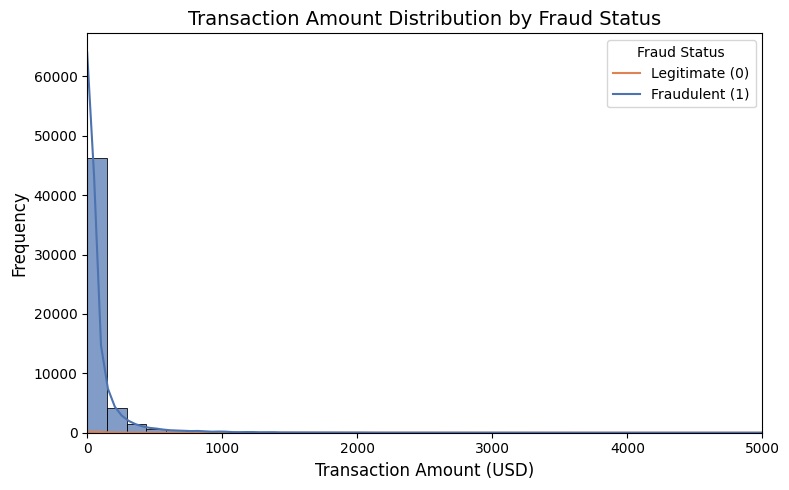

In [5]:
#exploritory visualizations
plt.figure(figsize=(8,5))
sns.histplot(
    data=fraud_train,
    x="Amount",
    hue="Fraud",
    bins=70,
    kde=True,
    palette=["#4C72B0", "#DD8452"],
    alpha=0.7
)

# Add manual labels and title
plt.title("Transaction Amount Distribution by Fraud Status", fontsize=14)
plt.xlabel("Transaction Amount (USD)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Legend and formatting
plt.legend(title="Fraud Status", labels=["Legitimate (0)", "Fraudulent (1)"])
plt.xlim(0, 5000)
plt.tight_layout()
plt.show()

The exploratory visualization displays the distribution of transaction amounts for both fraudulent and legitimate transactions. Most transactions happen at lower amounts, but fraudulent transactions show up slightly more frequent among higher-value purchases, suggesting that transaction amount may be a useful feature for identifying fraud.

### Models

In [6]:
# process data for ML
# create X and y for train
X_train = fraud_train.drop("Fraud", axis=1)
y_train = fraud_train["Fraud"]

# create X and y for test
X_test = fraud_test.drop("Fraud", axis=1)
y_test = fraud_test["Fraud"]

In [7]:
# train models
base_model = DecisionTreeClassifier(
    criterion='gini',
    class_weight={0: 1, 1: 2},  
    random_state=78
)


param_grid = {
    'max_depth': [4, 6, 8, 10, 12],
    'min_samples_split': [2, 5, 10, 20, 30]
}


grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_
y_pred = model.predict(X_test)
test_precision = precision_score(y_test, y_pred, zero_division=0)
test_recall = recall_score(y_test, y_pred, zero_division=0)

## Results

In [8]:
# report model metrics
production_precision = 0.9
production_recall = 0.8

print("Best Parameters:", grid_search.best_params_)
print("Test Precision:", round(test_precision, 3))
print("Test Recall:", round(test_recall, 3))
print("Production Precision:", production_precision)
print("Production Recall:", production_recall)

Best Parameters: {'max_depth': 4, 'min_samples_split': 30}
Test Precision: 0.925
Test Recall: 0.785
Production Precision: 0.9
Production Recall: 0.8


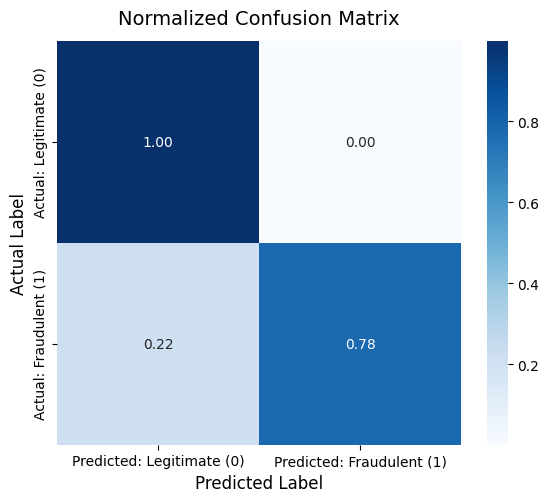

In [9]:
# summary figure
cm = confusion_matrix(y_test, y_pred, normalize='true')

# Create a labeled DataFrame
cm_df = pd.DataFrame(
    cm,
    index=["Actual: Legitimate (0)", "Actual: Fraudulent (1)"],
    columns=["Predicted: Legitimate (0)", "Predicted: Fraudulent (1)"]
)

# Plot the heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt=".2f", cmap="Blues", cbar=True, square=True)

# Formatting
plt.title("Normalized Confusion Matrix", fontsize=14, pad=12)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("Actual Label", fontsize=12)
plt.tight_layout()
plt.show()

In [10]:
# serialize model
dump(model, 'fraud.joblib')

['fraud.joblib']

The tuned Decision Tree model was trained using a grid search with cross-validation across varying depths (4–12) and minimum sample splits (2–30). The optimal parameters were max_depth = 4 and min_samples_split = 30. On the test set, the model achieved a precision of 0.925 and a recall of 0.785. Compared to the production goals of 0.9 precision and 0.8 recall, the model exceeded the precision target but slightly underperformed on recall.

The second visualization shows the normalized confusion matrix, which summarizes classification results. The matrix shows that 100% of legitimate transactions were correctly identified (true negatives), while 78% of fraudulent transactions were correctly detected (true positives). However, 22% of fraudulent cases were missed (false negatives), and no legitimate transactions were incorrectly flagged (false positives). These results indicate that the model performs conservatively, favoring accurate fraud flags over capturing every possible fraudulent case.

## Discussion

Although the model performs well in precision, its lower recall emphasizes a key compromise in fraud detection. This compromise is minimizing false alarms versus catching all fraudulent activity. In a banking context, false negatives missed frauds can lead to direct financial losses and reputational harm, while false positives can serve as an inconvenience to costumers and reduce the feeling of financial seafety and trust in that institution. Given this balance, the model’s behavior aligns with a cautious business approach, prioritizing customer experience and investigation efficiency.

I would recommend implementing the model in practice, but only as part of a integrated fraud-detection system. Its high precision makes it a strong first-stage filter for automated transaction screening, but the recall shortfall warrants including additional safeguards like human review for borderline cases or using ensemble models that better handle class imbalance.

The model’s benefits include interpretability, stability, and strong performance in avoiding false alarms. Its limitations lie in limited fraud sensitivity because of the imbalanced dataset and the inherent simplicity of a single decision tree. In the future, exploring re-sampling techniques, ensemble methods like Random Forest or Gradient Boosting, or cost-sensitive learning coulf be more effectient in penalizing missed fraud.

Thus, although this model would be useful for initial fraud screening, relying on it alone would not be ideal. A combined approach that builds on its strengths while addressing its weaknesses would yield a more balanced and robust fraud-detection system.